In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LightSource
import matplotlib.patheffects as path_effects
from mpl_toolkits.mplot3d import Axes3D
from osgeo import gdal
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

def create_conference_visualization(dem_file='uinta_merged.tif',
                                 output_file='uinta_basin_conference_3d.png',
                                 vertical_exaggeration=2,
                                 dpi=1200):
    """
    Create a professional conference-level 3D visualization of the Uinta Basin
    """
    # Set up the figure with high-quality settings
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(32, 24))

    # Create custom GridSpec with proper spacing
    gs = GridSpec(2, 3, figure=fig,
                 height_ratios=[2, 1],
                 width_ratios=[1, 1, 0.8],
                 hspace=0.3,
                 wspace=0.2)

    # Load DEM data
    dem = gdal.Open(dem_file)
    band = dem.GetRasterBand(1)
    data = band.ReadAsArray()
    geotransform = dem.GetGeoTransform()

    # Create coordinate arrays
    ny, nx = data.shape
    x = np.linspace(geotransform[0], geotransform[0] + nx*geotransform[1], nx)
    y = np.linspace(geotransform[3], geotransform[3] + ny*geotransform[5], ny)
    X, Y = np.meshgrid(x, y)

    # Downsample for better performance
    downsample = 15
    X = X[::downsample, ::downsample]
    Y = Y[::downsample, ::downsample]
    Z = data[::downsample, ::downsample]

    # Enhanced terrain colormap
    terrain_colors = [
        '#1a0f00',  # Darkest brown
        '#2d1606',
        '#654321',
        '#8b4513',
        '#a0522d',
        '#deb887',
        '#d2b48c',
        '#f5deb3'   # Lightest
    ]
    terrain_cmap = LinearSegmentedColormap.from_list('terrain_enhanced', terrain_colors)

    # Cold pool colormap
    cold_pool_colors = [
        '#000033',  # Darkest blue
        '#000066',
        '#000099',
        '#0000cc',
        '#4169e1',
        '#87ceeb'   # Lightest blue
    ]
    cold_pool_cmap = LinearSegmentedColormap.from_list('cold_pool', cold_pool_colors)

    # Define views
    views = [
        {'elev': 35, 'azim': 225, 'title': 'Southwest Perspective\nWasatch Range Influence',
         'position': (0,0)},
        {'elev': 35, 'azim': 135, 'title': 'Southeast Perspective\nBasin Structure',
         'position': (0,1)},
        {'elev': 25, 'azim': 180, 'title': 'Cold Pool Formation\nand Snow Shadow Effect',
         'position': (0,2)},
        {'elev': 45, 'azim': 180, 'title': 'Topographic Overview\nElevation Analysis',
         'position': (1, slice(0,3))}
    ]

    def add_enhanced_text(ax, x, y, z, text, **kwargs):
        txt = ax.text(x, y, z, text, **kwargs)
        txt.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground='black'),
            path_effects.Normal()
        ])
        return txt

    axes = []
    for view in views:
        # Create 3D subplot
        if isinstance(view['position'][1], slice):
            ax = fig.add_subplot(gs[view['position'][0], view['position'][1]], projection='3d')
        else:
            ax = fig.add_subplot(gs[view['position']], projection='3d')
        axes.append(ax)

        # Enhanced surface plot
        ls = LightSource(azdeg=315, altdeg=45)
        rgb = ls.shade(Z, cmap=terrain_cmap, vert_exag=vertical_exaggeration)

        surf = ax.plot_surface(X, Y, Z * vertical_exaggeration,
                             facecolors=rgb,
                             linewidth=0,
                             antialiased=True,
                             shade=False)

        # Add cold pool visualization
        if view['position'] == (0,2):
            cold_pool_height = np.min(Z) + 300
            cold_pool_mask = Z < cold_pool_height

            # Add multiple layers for depth effect
            for i in range(5):
                height = cold_pool_height - i * 20
                alpha = 0.1 - i * 0.015
                ax.plot_surface(X, Y,
                              np.where(Z < height, height, np.nan),
                              cmap=cold_pool_cmap,
                              alpha=alpha)

            # Add scatter points to show air movement
            n_points = 50
            x_points = np.random.uniform(X.min(), X.max(), n_points)
            y_points = np.random.uniform(Y.mean()-0.1, Y.mean()+0.1, n_points)
            z_points = np.random.uniform(Z.min(), cold_pool_height, n_points)

            ax.scatter(x_points, y_points, z_points,
                      c='white', alpha=0.3, s=10)

        # Customize view
        ax.view_init(elev=view['elev'], azim=view['azim'])
        ax.set_title(view['title'], fontsize=16, pad=20, color='white',
                    path_effects=[path_effects.withStroke(linewidth=3, foreground='black')])

        # Enhanced label styling
        ax.set_xlabel('Longitude', labelpad=10)
        ax.set_ylabel('Latitude', labelpad=10)
        ax.set_zlabel('Elevation (m)', labelpad=10)

        for label in [ax.xaxis.label, ax.yaxis.label, ax.zaxis.label]:
            label.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])

        # Add key locations
        locations = {
            'Duchesne': (-110.0, 40.2, 1700, 'Major Population Center'),
            'Roosevelt': (-109.9, 40.3, 1650, 'Oil & Gas Activity'),
            'Vernal': (-109.5, 40.4, 1600, 'Regional Hub'),
            'Wasatch Range': (-110.2, 40.5, 3000, 'Orographic Barrier'),
            'Split Mountain': (-109.25, 40.45, 2500, 'Topographic Feature')
        }

        for name, (lon, lat, elev, desc) in locations.items():
            add_enhanced_text(ax, lon, lat, elev * vertical_exaggeration,
                            f'{name}\n{desc}',
                            color='white',
                            fontsize=10,
                            ha='center',
                            va='bottom')
            ax.scatter([lon], [lat], [elev * vertical_exaggeration],
                      c='white',
                      s=100,
                      edgecolor='black',
                      linewidth=2)

    # Add main title
    title = fig.suptitle('Uinta Basin: Topography, Cold Pool Formation, and Snow Shadow Effect',
                        fontsize=24, y=0.95, color='white')
    title.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])

    # Add detailed legend
    legend_text = (
        'Key Features and Processes:\n\n'
        '• Wasatch Range Barrier Effect\n'
        '  - Orographic lifting\n'
        '  - Precipitation shadowing\n\n'
        '• Cold Pool Formation\n'
        '  - Temperature inversion\n'
        '  - Vertical extent: ~300m\n'
        '  - Duration: Days to weeks\n\n'
        '• Environmental Impact\n'
        '  - Ozone accumulation\n'
        '  - Air quality concerns\n'
        '  - Limited vertical mixing\n\n'
        '• Basin Characteristics\n'
        f'  - Elevation range: {int(np.min(Z))}-{int(np.max(Z))}m\n'
        '  - Complex topography\n'
        '  - Limited precipitation'
    )

    # Add legend with styling
    fig.text(0.02, 0.02, legend_text,
            color='white',
            fontsize=14,
            ha='left',
            va='bottom',
            bbox=dict(facecolor='black',
                     alpha=0.7,
                     edgecolor='white',
                     boxstyle='round,pad=1'))

    # Save high-resolution figure
    plt.savefig(output_file,
                dpi=dpi,
                bbox_inches='tight',
                facecolor='black',
                edgecolor='none',
                pad_inches=0.5)
    plt.close()

if __name__ == '__main__':
    create_conference_visualization()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LightSource
import matplotlib.patheffects as path_effects
from mpl_toolkits.mplot3d import Axes3D
from osgeo import gdal
from matplotlib.gridspec import GridSpec

def create_basin_visualization(dem_file='uinta_merged.tif',
                             output_file='uinta_basin_focus.png',
                             vertical_exaggeration=2,
                             dpi=1200):
    """
    Create visualization focusing on the Uinta Basin floor and shape
    """
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(32, 24))

    # Create custom GridSpec
    gs = GridSpec(2, 2, figure=fig,
                 height_ratios=[2, 1],
                 hspace=0.3,
                 wspace=0.2)

    # Load DEM data
    dem = gdal.Open(dem_file)
    band = dem.GetRasterBand(1)
    data = band.ReadAsArray()
    geotransform = dem.GetGeoTransform()

    # Create coordinate arrays
    ny, nx = data.shape
    x = np.linspace(geotransform[0], geotransform[0] + nx*geotransform[1], nx)
    y = np.linspace(geotransform[3], geotransform[3] + ny*geotransform[5], ny)
    X, Y = np.meshgrid(x, y)

    # Focus on basin area (adjust these coordinates as needed)
    mask = ((X >= -110.25) & (X <= -109.0) &
            (Y >= 39.75) & (Y <= 40.75))

    # Mask elevations to focus on basin floor (adjust threshold as needed)
    elevation_mask = data < 2500  # Adjust this threshold to capture basin floor

    # Combine masks
    final_mask = mask & elevation_mask

    # Apply masks
    X_masked = np.where(final_mask, X, np.nan)
    Y_masked = np.where(final_mask, Y, np.nan)
    Z_masked = np.where(final_mask, data, np.nan)

    # Downsample for better performance
    downsample = 15
    X_masked = X_masked[::downsample, ::downsample]
    Y_masked = Y_masked[::downsample, ::downsample]
    Z_masked = Z_masked[::downsample, ::downsample]

    # Enhanced terrain colormap focusing on basin colors
    terrain_colors = [
        '#2F1810',  # Dark brown
        '#3B2216',  # Medium brown
        '#51331F',  # Light brown
        '#6B4423',  # Tan
        '#8B6B4D',  # Light tan
    ]
    terrain_cmap = LinearSegmentedColormap.from_list('basin_terrain', terrain_colors)

    # Define views optimized for basin visualization
    views = [
        {'elev': 25, 'azim': 225, 'title': 'Basin Floor Structure\nSouthwest View',
         'position': (0,0)},
        {'elev': 25, 'azim': 135, 'title': 'Basin Depression\nSoutheast View',
         'position': (0,1)},
        {'elev': 45, 'azim': 180, 'title': 'Basin Overview\nTopographic Analysis',
         'position': (1, slice(0,2))}
    ]

    def add_enhanced_text(ax, x, y, z, text, **kwargs):
        txt = ax.text(x, y, z, text, **kwargs)
        txt.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground='black'),
            path_effects.Normal()
        ])
        return txt

    axes = []
    for view in views:
        # Create 3D subplot
        if isinstance(view['position'][1], slice):
            ax = fig.add_subplot(gs[view['position'][0], view['position'][1]], projection='3d')
        else:
            ax = fig.add_subplot(gs[view['position']], projection='3d')
        axes.append(ax)

        # Enhanced surface plot
        ls = LightSource(azdeg=315, altdeg=45)
        rgb = ls.shade(Z_masked, cmap=terrain_cmap, vert_exag=vertical_exaggeration)

        surf = ax.plot_surface(X_masked, Y_masked, Z_masked * vertical_exaggeration,
                             facecolors=rgb,
                             linewidth=0,
                             antialiased=True,
                             shade=False)

        # Customize view
        ax.view_init(elev=view['elev'], azim=view['azim'])
        ax.set_title(view['title'], fontsize=16, pad=20, color='white',
                    path_effects=[path_effects.withStroke(linewidth=3, foreground='black')])

        # Add key locations focusing on basin floor
        locations = {
            'Duchesne': (-110.0, 40.2, 1700, 'Basin Floor'),
            'Roosevelt': (-109.9, 40.3, 1650, 'Oil & Gas Activity'),
            'Vernal': (-109.5, 40.4, 1600, 'Eastern Basin'),
            'Basin Center': (-109.7, 40.3, 1550, 'Deepest Point')
        }

        for name, (lon, lat, elev, desc) in locations.items():
            if np.any(~np.isnan(X_masked)):  # Only add if within masked region
                add_enhanced_text(ax, lon, lat, elev * vertical_exaggeration,
                                f'{name}\n{desc}\n{elev}m',
                                color='white',
                                fontsize=10,
                                ha='center',
                                va='bottom')
                ax.scatter([lon], [lat], [elev * vertical_exaggeration],
                          c='white',
                          s=100,
                          edgecolor='black',
                          linewidth=2)

    # Add main title
    title = fig.suptitle('Uinta Basin Floor Topography',
                        fontsize=24, y=0.95, color='white')
    title.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])

    # Add basin-focused legend
    legend_text = (
        'Basin Characteristics:\n\n'
        '• Basin Floor\n'
        f'  - Elevation range: {int(np.nanmin(Z_masked))}-{int(2500)}m\n'
        '  - Depression depth: ~1000m\n'
        '  - Basin width: ~100km\n\n'
        '• Cold Pool Formation Zone\n'
        '  - Primary accumulation area\n'
        '  - Limited vertical mixing\n'
        '  - Temperature inversion zone\n\n'
        '• Environmental Significance\n'
        '  - Snow accumulation zone\n'
        '  - Air quality impact region\n'
        '  - Oil & gas development area'
    )

    fig.text(0.02, 0.02, legend_text,
            color='white',
            fontsize=14,
            ha='left',
            va='bottom',
            bbox=dict(facecolor='black',
                     alpha=0.7,
                     edgecolor='white',
                     boxstyle='round,pad=1'))

    # Save high-resolution figure
    plt.savefig(output_file,
                dpi=dpi,
                bbox_inches='tight',
                facecolor='black',
                edgecolor='none',
                pad_inches=0.5)
    plt.close()

if __name__ == '__main__':
    create_basin_visualization()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LightSource
import matplotlib.patheffects as path_effects
from mpl_toolkits.mplot3d import Axes3D
from osgeo import gdal
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors

def create_shadow_visualization(dem_file='uinta_merged.tif',
                              output_file='uinta_shadow_effect.png',
                              vertical_exaggeration=2,
                              dpi=1200):
    """
    Create visualization emphasizing basin shape and snow shadow effect
    """
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(32, 24))

    # Create custom GridSpec
    gs = GridSpec(2, 2, figure=fig,
                 height_ratios=[2, 1],
                 hspace=0.3,
                 wspace=0.2)

    # Load DEM data
    dem = gdal.Open(dem_file)
    band = dem.GetRasterBand(1)
    data = band.ReadAsArray()
    geotransform = dem.GetGeoTransform()

    # Create coordinate arrays
    ny, nx = data.shape
    x = np.linspace(geotransform[0], geotransform[0] + nx*geotransform[1], nx)
    y = np.linspace(geotransform[3], geotransform[3] + ny*geotransform[5], ny)
    X, Y = np.meshgrid(x, y)

    # Downsample for better performance
    downsample = 15
    X = X[::downsample, ::downsample]
    Y = Y[::downsample, ::downsample]
    Z = data[::downsample, ::downsample]

    # Create custom colormap that emphasizes basin shape
    colors = [
        (0.6, 0.4, 0.2),      # Brown for lower elevations
        (0.7, 0.5, 0.3),      # Lighter brown
        (0.8, 0.6, 0.4),      # Even lighter brown
        (0.9, 0.7, 0.5),      # Tan
        (0.95, 0.85, 0.7),    # Light tan
        (1.0, 0.95, 0.9),     # Nearly white for peaks
    ]

    # Create custom normalization to emphasize basin
    basin_elevation = 1800  # Approximate basin floor elevation
    mountain_elevation = 3000  # Approximate mountain elevation

    # Create enhanced views
    views = [
        {'elev': 30, 'azim': 245,
         'title': 'Snow Shadow Effect\nWasatch Range Influence',
         'position': (0,0)},
        {'elev': 25, 'azim': 135,
         'title': 'Basin Structure\nand Mountain Barriers',
         'position': (0,1)},
        {'elev': 45, 'azim': 180,
         'title': 'Topographic Overview\nPrecipitation Patterns',
         'position': (1, slice(0,2))}
    ]

    def add_enhanced_text(ax, x, y, z, text, **kwargs):
        txt = ax.text(x, y, z, text, **kwargs)
        txt.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground='black'),
            path_effects.Normal()
        ])
        return txt

    for view in views:
        # Create 3D subplot
        if isinstance(view['position'][1], slice):
            ax = fig.add_subplot(gs[view['position'][0], view['position'][1]],
                               projection='3d')
        else:
            ax = fig.add_subplot(gs[view['position']], projection='3d')

        # Enhanced lighting from the west (Wasatch direction)
        ls = LightSource(azdeg=270, altdeg=45)

        # Plot terrain with enhanced shading
        terrain_cmap = LinearSegmentedColormap.from_list('terrain', colors)
        rgb = ls.shade(Z, cmap=terrain_cmap,
                      vert_exag=vertical_exaggeration,
                      blend_mode='overlay')

        surf = ax.plot_surface(X, Y, Z * vertical_exaggeration,
                             facecolors=rgb,
                             linewidth=0,
                             antialiased=True,
                             shade=False)

        # Add snow shadow effect indication
        if view['position'] == (0,0):
            # Add semi-transparent blue layer for snow accumulation
            snow_level = np.where(Z > 2500, Z, np.nan)
            ax.plot_surface(X, Y, snow_level * vertical_exaggeration,
                          color='white', alpha=0.2)

            # Add shadow zone indication
            shadow_mask = (X < -109.7) & (Z < 2200)
            ax.plot_surface(X, Y,
                          np.where(shadow_mask, Z, np.nan) * vertical_exaggeration,
                          color='blue', alpha=0.1)

        # Customize view
        ax.view_init(elev=view['elev'], azim=view['azim'])
        ax.set_title(view['title'], fontsize=16, pad=20, color='white',
                    path_effects=[path_effects.withStroke(linewidth=3,
                                                        foreground='black')])

        # Add key features
        features = {
            'Wasatch Range': (-110.2, 40.5, 3000, 'Orographic Barrier'),
            'Shadow Zone': (-109.8, 40.3, 1600, 'Reduced Precipitation'),
            'Basin Floor': (-109.5, 40.3, 1550, 'Cold Pool Formation'),
            'Duchesne': (-110.0, 40.2, 1700, 'Western Basin'),
            'Vernal': (-109.5, 40.4, 1600, 'Eastern Basin')
        }

        for name, (lon, lat, elev, desc) in features.items():
            add_enhanced_text(ax, lon, lat, elev * vertical_exaggeration,
                            f'{name}\n{desc}',
                            color='white',
                            fontsize=12,
                            ha='center',
                            va='bottom')
            ax.scatter([lon], [lat], [elev * vertical_exaggeration],
                      c='white', s=100, edgecolor='black', linewidth=2)

        # Enhance axes
        ax.set_xlabel('Longitude', labelpad=20)
        ax.set_ylabel('Latitude', labelpad=20)
        ax.set_zlabel('Elevation (m)', labelpad=20)

        for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
            axis.label.set_path_effects([path_effects.withStroke(linewidth=3,
                                                               foreground='black')])

    # Add main title
    title = fig.suptitle(
        'Uinta Basin Snow Shadow Effect and Basin Morphology',
        fontsize=28, y=0.95, color='white')
    title.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])

    # Add process explanation
    explanation_text = (
        'Snow Shadow Process:\n\n'
        '• Wasatch Range Barrier\n'
        '  - Forces air masses upward\n'
        '  - Causes precipitation on windward side\n\n'
        '• Shadow Effect\n'
        '  - Drier air descends into basin\n'
        '  - Reduced snowfall in basin\n'
        '  - Creates precipitation gradient\n\n'
        '• Basin Characteristics\n'
        f'  - Elevation drop: {int(np.max(Z)-np.min(Z))}m\n'
        '  - Pronounced depression\n'
        '  - Cold pool formation zone'
    )

    fig.text(0.02, 0.02, explanation_text,
            color='white',
            fontsize=14,
            ha='left',
            va='bottom',
            bbox=dict(facecolor='black',
                     alpha=0.7,
                     edgecolor='white',
                     boxstyle='round,pad=1'))

    # Save high-resolution figure
    plt.savefig(output_file,
                dpi=dpi,
                bbox_inches='tight',
                facecolor='black',
                edgecolor='none',
                pad_inches=0.5)
    plt.close()

if __name__ == '__main__':
    create_shadow_visualization()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LightSource
import matplotlib.patheffects as path_effects
from mpl_toolkits.mplot3d import Axes3D
from osgeo import gdal
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors

def create_shadow_visualization(dem_file='uinta_merged.tif',
                              output_file='uinta_shadow_effect.png',
                              vertical_exaggeration=2,
                              dpi=1200):
    """
    Create visualization emphasizing basin shape and snow shadow effect
    """
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(32, 24))

    # Create custom GridSpec
    gs = GridSpec(2, 2, figure=fig,
                 height_ratios=[2, 1],
                 hspace=0.3,
                 wspace=0.2)

    # Load DEM data
    dem = gdal.Open(dem_file)
    band = dem.GetRasterBand(1)
    data = band.ReadAsArray()
    geotransform = dem.GetGeoTransform()

    # Create coordinate arrays
    ny, nx = data.shape
    x = np.linspace(geotransform[0], geotransform[0] + nx*geotransform[1], nx)
    y = np.linspace(geotransform[3], geotransform[3] + ny*geotransform[5], ny)
    X, Y = np.meshgrid(x, y)

    # Downsample for better performance
    downsample = 15
    X = X[::downsample, ::downsample]
    Y = Y[::downsample, ::downsample]
    Z = data[::downsample, ::downsample]

    # Create custom colormap that emphasizes basin shape
    colors = [
        (0.6, 0.4, 0.2),      # Brown for lower elevations
        (0.7, 0.5, 0.3),      # Lighter brown
        (0.8, 0.6, 0.4),      # Even lighter brown
        (0.9, 0.7, 0.5),      # Tan
        (0.95, 0.85, 0.7),    # Light tan
        (1.0, 0.95, 0.9),     # Nearly white for peaks
    ]

    # Create custom normalization to emphasize basin
    basin_elevation = 1800  # Approximate basin floor elevation
    mountain_elevation = 3000  # Approximate mountain elevation

    # Create enhanced views
    views = [
        {'elev': 30, 'azim': 245,
         'title': 'Snow Shadow Effect\nWasatch Range Influence',
         'position': (0,0)},
        {'elev': 25, 'azim': 135,
         'title': 'Basin Structure\nand Mountain Barriers',
         'position': (0,1)},
        {'elev': 45, 'azim': 180,
         'title': 'Topographic Overview\nPrecipitation Patterns',
         'position': (1, slice(0,2))}
    ]

    def add_enhanced_text(ax, x, y, z, text, **kwargs):
        txt = ax.text(x, y, z, text, **kwargs)
        txt.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground='black'),
            path_effects.Normal()
        ])
        return txt

    for view in views:
        # Create 3D subplot
        if isinstance(view['position'][1], slice):
            ax = fig.add_subplot(gs[view['position'][0], view['position'][1]],
                               projection='3d')
        else:
            ax = fig.add_subplot(gs[view['position']], projection='3d')

        # Enhanced lighting from the west (Wasatch direction)
        ls = LightSource(azdeg=270, altdeg=45)

        # Plot terrain with enhanced shading
        terrain_cmap = LinearSegmentedColormap.from_list('terrain', colors)
        rgb = ls.shade(Z, cmap=terrain_cmap,
                      vert_exag=vertical_exaggeration,
                      blend_mode='overlay')

        surf = ax.plot_surface(X, Y, Z * vertical_exaggeration,
                             facecolors=rgb,
                             linewidth=0,
                             antialiased=True,
                             shade=False)

        # Add snow shadow effect indication
        if view['position'] == (0,0):
            # Add semi-transparent blue layer for snow accumulation
            snow_level = np.where(Z > 2500, Z, np.nan)
            ax.plot_surface(X, Y, snow_level * vertical_exaggeration,
                          color='white', alpha=0.2)

            # Add shadow zone indication
            shadow_mask = (X < -109.7) & (Z < 2200)
            ax.plot_surface(X, Y,
                          np.where(shadow_mask, Z, np.nan) * vertical_exaggeration,
                          color='blue', alpha=0.1)

        # Customize view
        ax.view_init(elev=view['elev'], azim=view['azim'])
        ax.set_title(view['title'], fontsize=16, pad=20, color='white',
                    path_effects=[path_effects.withStroke(linewidth=3,
                                                        foreground='black')])

        # Add key features
        features = {
            'Wasatch Range': (-110.2, 40.5, 3000, 'Orographic Barrier'),
            'Shadow Zone': (-109.8, 40.3, 1600, 'Reduced Precipitation'),
            'Basin Floor': (-109.5, 40.3, 1550, 'Cold Pool Formation'),
            'Duchesne': (-110.0, 40.2, 1700, 'Western Basin'),
            'Vernal': (-109.5, 40.4, 1600, 'Eastern Basin')
        }

        for name, (lon, lat, elev, desc) in features.items():
            add_enhanced_text(ax, lon, lat, elev * vertical_exaggeration,
                            f'{name}\n{desc}',
                            color='white',
                            fontsize=12,
                            ha='center',
                            va='bottom')
            ax.scatter([lon], [lat], [elev * vertical_exaggeration],
                      c='white', s=100, edgecolor='black', linewidth=2)

        # Enhance axes
        ax.set_xlabel('Longitude', labelpad=20)
        ax.set_ylabel('Latitude', labelpad=20)
        ax.set_zlabel('Elevation (m)', labelpad=20)

        for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
            axis.label.set_path_effects([path_effects.withStroke(linewidth=3,
                                                               foreground='black')])

    # Add main title
    title = fig.suptitle(
        'Uinta Basin Snow Shadow Effect and Basin Morphology',
        fontsize=28, y=0.95, color='white')
    title.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])

    # Add process explanation
    explanation_text = (
        'Snow Shadow Process:\n\n'
        '• Wasatch Range Barrier\n'
        '  - Forces air masses upward\n'
        '  - Causes precipitation on windward side\n\n'
        '• Shadow Effect\n'
        '  - Drier air descends into basin\n'
        '  - Reduced snowfall in basin\n'
        '  - Creates precipitation gradient\n\n'
        '• Basin Characteristics\n'
        f'  - Elevation drop: {int(np.max(Z)-np.min(Z))}m\n'
        '  - Pronounced depression\n'
        '  - Cold pool formation zone'
    )

    fig.text(0.02, 0.02, explanation_text,
            color='white',
            fontsize=14,
            ha='left',
            va='bottom',
            bbox=dict(facecolor='black',
                     alpha=0.7,
                     edgecolor='white',
                     boxstyle='round,pad=1'))

    # Save high-resolution figure
    plt.savefig(output_file,
                dpi=dpi,
                bbox_inches='tight',
                facecolor='black',
                edgecolor='none',
                pad_inches=0.5)
    plt.close()

if __name__ == '__main__':
    create_shadow_visualization()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LightSource
import matplotlib.patheffects as path_effects
from mpl_toolkits.mplot3d import Axes3D
from osgeo import gdal
from matplotlib.gridspec import GridSpec

def create_basin_viz(dem_file='uinta_merged.tif',
                    output_file='uinta_basin_final.png',
                    vertical_exag=2,
                    dpi=1200):
    """
    Create 3D visualization of Uinta Basin emphasizing basin shape and snow shadow
    """
    # Setup
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(32, 24))
    gs = GridSpec(2, 2, figure=fig, height_ratios=[2, 1], hspace=0.3, wspace=0.2)

    # Load DEM
    dem = gdal.Open(dem_file)
    data = dem.GetRasterBand(1).ReadAsArray()
    gt = dem.GetGeoTransform()

    # Create coordinate arrays
    ny, nx = data.shape
    x = np.linspace(gt[0], gt[0] + nx*gt[1], nx)
    y = np.linspace(gt[3], gt[3] + ny*gt[5], ny)
    X, Y = np.meshgrid(x, y)

    # Downsample for performance (adjust factor if needed)
    ds_factor = 15
    X = X[::ds_factor, ::ds_factor]
    Y = Y[::ds_factor, ::ds_factor]
    Z = data[::ds_factor, ::ds_factor]

    # Create enhanced colormap for terrain
    terrain_colors = [
        '#2F1810',  # Deep basin (darkest)
        '#3B2216',
        '#513620',
        '#6B4423',
        '#8B6B4D',
        '#A69376',  # Higher elevations
        '#C7B8A1',
        '#E2D5C3',  # Peaks (lightest)
    ]
    terrain_cmap = LinearSegmentedColormap.from_list('terrain', terrain_colors)

    # Define optimal viewing angles
    views = [
        {'elev': 35, 'azim': 245, 'title': 'Snow Shadow Effect & Basin Shape',
         'position': (0,0)},
        {'elev': 35, 'azim': 135, 'title': 'Basin Cross-Section View',
         'position': (0,1)},
        {'elev': 45, 'azim': 180, 'title': 'Topographic Overview',
         'position': (1, slice(0,2))}
    ]

    # Add text with shadow effect
    def add_text(ax, x, y, z, text, **kwargs):
        txt = ax.text(x, y, z, text, **kwargs)
        txt.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground='black'),
            path_effects.Normal()
        ])
        return txt

    # Plot each view
    for view in views:
        if isinstance(view['position'][1], slice):
            ax = fig.add_subplot(gs[view['position'][0], view['position'][1]],
                               projection='3d')
        else:
            ax = fig.add_subplot(gs[view['position']], projection='3d')

        # Enhanced lighting
        ls = LightSource(azdeg=270, altdeg=45)
        rgb = ls.shade(Z, cmap=terrain_cmap,
                      vert_exag=vertical_exag,
                      blend_mode='overlay')

        # Plot surface
        surf = ax.plot_surface(X, Y, Z * vertical_exag,
                             facecolors=rgb,
                             linewidth=0,
                             antialiased=True,
                             shade=False)

        # Set view angle
        ax.view_init(elev=view['elev'], azim=view['azim'])

        # Title and labels
        ax.set_title(view['title'], fontsize=16, pad=20, color='white',
                    path_effects=[path_effects.withStroke(linewidth=3,
                                                        foreground='black')])

        # Axis labels
        ax.set_xlabel('Longitude', labelpad=20)
        ax.set_ylabel('Latitude', labelpad=20)
        ax.set_zlabel('Elevation (m)', labelpad=20)

        # Key locations and features
        locations = {
            'Wasatch Range': (-110.2, 40.5, 3000, 'Orographic Barrier'),
            'Basin Floor': (-109.7, 40.3, 1600, 'Cold Pool Formation Zone'),
            'Duchesne': (-110.0, 40.2, 1700, 'Western Basin'),
            'Vernal': (-109.5, 40.4, 1600, 'Eastern Basin'),
            'Shadow Zone': (-109.8, 40.3, 1800, 'Reduced Precipitation')
        }

        for name, (lon, lat, elev, desc) in locations.items():
            add_text(ax, lon, lat, elev * vertical_exag,
                    f'{name}\n{desc}',
                    color='white',
                    fontsize=12,
                    ha='center',
                    va='bottom')
            ax.scatter([lon], [lat], [elev * vertical_exag],
                      c='white', s=100, edgecolor='black', linewidth=2)

    # Main title
    title = fig.suptitle('Uinta Basin: Snow Shadow Effect & Basin Morphology',
                        fontsize=28, y=0.95, color='white')
    title.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])

    # Add legend
    legend_text = (
        'Uinta Basin Features:\n\n'
        '• Snow Shadow Process\n'
        '  - Wasatch Range blocks moisture\n'
        '  - Reduced snowfall in basin\n'
        '  - Enhanced in winter months\n\n'
        '• Basin Characteristics\n'
        f'  - Elevation range: {int(np.min(Z))}-{int(np.max(Z))}m\n'
        '  - Pronounced depression\n'
        '  - Cold pool formation zone\n\n'
        '• Environmental Impact\n'
        '  - Temperature inversions\n'
        '  - Air quality concerns\n'
        '  - Winter ozone formation'
    )

    fig.text(0.02, 0.02, legend_text,
            color='white',
            fontsize=14,
            ha='left',
            va='bottom',
            bbox=dict(facecolor='black',
                     alpha=0.7,
                     edgecolor='white',
                     boxstyle='round,pad=1'))

    # Save figure
    plt.savefig(output_file,
                dpi=dpi,
                bbox_inches='tight',
                facecolor='black',
                edgecolor='none',
                pad_inches=0.5)
    plt.close()

if __name__ == '__main__':
    create_basin_viz()

In [7]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LightSource
import contextily as ctx
import earthpy.spatial as es

# Read DEM
with rasterio.open('../data/tif/uinta_merged.tif') as src:
    elevation = src.read(1)
    # Get the spatial parameters
    transform = src.transform

# Create coordinate matrices
ny, nx = elevation.shape
x = np.linspace(0, nx-1, nx)
y = np.linspace(0, ny-1, ny)
x, y = np.meshgrid(x, y)

# Set up the figure for high-quality rendering
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={'projection': '3d'})

# Calculate hillshade for enhanced visualization
ls = LightSource(azdeg=315, altdeg=45)
rgb = ls.shade(elevation, cmap=cm.terrain, vert_exag=1.5, blend_mode='soft')

# Plot surface with enhanced visualization
surf = ax.plot_surface(x, y, elevation,
                      facecolors=rgb,
                      linewidth=0,
                      antialiased=True,
                      shade=False)

# Customize viewing angle for best shadow effect
ax.view_init(elev=45, azim=225)

# Enhance labels and title
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Distance (km)')
ax.set_zlabel('Elevation (m)')
ax.set_title('Uinta Mountains Topographic Relief\nSnow Shadow Analysis',
             pad=20, fontsize=16, fontweight='bold')

# Add colorbar
norm = plt.Normalize(elevation.min(), elevation.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap=cm.terrain)
cb = fig.colorbar(sm, ax=ax, label='Elevation (m)')

# Enhance figure properties for publication
plt.tight_layout()

# Save in high resolution
plt.savefig('uinta_3d_terrain_poster.png', dpi=300, bbox_inches='tight')
plt.close()

In [8]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.ndimage import gaussian_filter
import seaborn as sns

# Read DEM
with rasterio.open('../data/tif/uinta_merged.tif') as src:
    elevation = src.read(1)

# Apply Gaussian smoothing
smoothed_elevation = gaussian_filter(elevation, sigma=3)

# Create meshgrid with higher resolution
ny, nx = smoothed_elevation.shape
x = np.linspace(0, nx-1, nx)
y = np.linspace(0, ny-1, ny)
x, y = np.meshgrid(x, y)

# Set up plot
fig = plt.figure(figsize=(20, 20), facecolor='black')
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('black')

# Plot surface with enhanced appearance
surf = ax.plot_surface(x, y, smoothed_elevation,
                      cmap='viridis',
                      linewidth=0,
                      antialiased=True,
                      rcount=200,  # Increase resolution
                      ccount=200,
                      alpha=0.9)

# Customize viewing angle
ax.view_init(elev=35, azim=225)

# Style enhancements
ax.xaxis.set_pane_color((0, 0, 0))
ax.yaxis.set_pane_color((0, 0, 0))
ax.zaxis.set_pane_color((0, 0, 0))
ax.grid(True, alpha=0.3)

# Labels and title
plt.title('Uinta Mountains Topographic Relief\nSnow Shadow Analysis',
          color='white', pad=20, fontsize=16)
ax.set_xlabel('Distance (km)', color='white', labelpad=10)
ax.set_ylabel('Distance (km)', color='white', labelpad=10)
ax.set_zlabel('Elevation (m)', color='white', labelpad=10)

# Colorbar
cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, pad=0.1)
cb.ax.yaxis.set_tick_params(color='white')
cb.set_label('Elevation (m)', color='white')

plt.savefig('uinta_3d_terrain_smooth.png', dpi=300, bbox_inches='tight',
            facecolor='black', edgecolor='none')
plt.close()

In [13]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter, sobel, maximum_filter
from matplotlib.colors import LightSource
import matplotlib.patheffects as pe
from skimage.feature import peak_local_max

# Read DEM
with rasterio.open('../data/tif/uinta_merged.tif') as src:
    elevation = src.read(1)

# Smooth elevation
smoothed_elevation = gaussian_filter(elevation, sigma=2)

# Terrain analysis
dx = sobel(smoothed_elevation, axis=1)
dy = sobel(smoothed_elevation, axis=0)
slope = np.pi/2 - np.arctan(np.sqrt(dx*dx + dy*dy))
aspect = np.arctan2(-dx, dy)
roughness = maximum_filter(smoothed_elevation, size=5) - maximum_filter(smoothed_elevation, size=3)

# Snow accumulation model
snow_accum = np.zeros_like(smoothed_elevation)
snow_accum[slope < np.pi/6] += 1
snow_accum[aspect > 0] += 0.5

# Setup plot
ny, nx = smoothed_elevation.shape
x, y = np.meshgrid(np.arange(nx), np.arange(ny))

plt.style.use('dark_background')
fig = plt.figure(figsize=(24, 20))
ax = fig.add_subplot(111, projection='3d')

# Custom colormap
colors = ['#1e4462', '#406d8c', '#6199b8', '#81b5d4', '#a3cce3', '#c5e2f2', '#ffffff']
custom_cmap = LinearSegmentedColormap.from_list('custom', colors)

# Multi-directional lighting
ls1 = LightSource(azdeg=315, altdeg=45)
ls2 = LightSource(azdeg=135, altdeg=30)
rgb1 = ls1.shade(smoothed_elevation, cmap=custom_cmap, vert_exag=2.0)
rgb2 = ls2.shade(smoothed_elevation, cmap=custom_cmap, vert_exag=2.0)
rgb = (rgb1 + rgb2) / 2

# Main surface plot
surf = ax.plot_surface(x, y, smoothed_elevation,
                      facecolors=rgb,
                      linewidth=0,
                      antialiased=True,
                      rcount=300,
                      ccount=300)

# Add snow and terrain features
peaks = peak_local_max(smoothed_elevation, min_distance=50, threshold_rel=0.1)
snow_mask = snow_accum > np.median(snow_accum)
valleys = np.logical_and(roughness < np.percentile(roughness, 10),
                        slope < np.percentile(slope, 20))

ax.scatter(x[snow_mask][::100], y[snow_mask][::100],
          smoothed_elevation[snow_mask][::100],
          c='white', alpha=0.1, s=1)

for peak in peaks:
    ax.scatter(x[peak[0], peak[1]], y[peak[0], peak[1]],
              smoothed_elevation[peak[0], peak[1]],
              c='red', marker='^', s=100)

ax.scatter(x[valleys][::100], y[valleys][::100],
          smoothed_elevation[valleys][::100],
          c='blue', alpha=0.2, s=1)

# Styling
ax.view_init(elev=35, azim=225)
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Labels
title = ax.set_title('Uinta Mountains Topographic Relief\nSnow Shadow Analysis',
                    color='white', pad=20, fontsize=20, fontweight='bold')
title.set_path_effects([pe.withStroke(linewidth=2, foreground='#1e4462')])

ax.set_xlabel('Distance (km)', labelpad=20)
ax.set_ylabel('Distance (km)', labelpad=20)
ax.set_zlabel('Elevation (m)', labelpad=20)

# Save
plt.savefig('uinta_3d_terrain_advanced.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='black',
            edgecolor='none')
plt.close()

KeyboardInterrupt: 

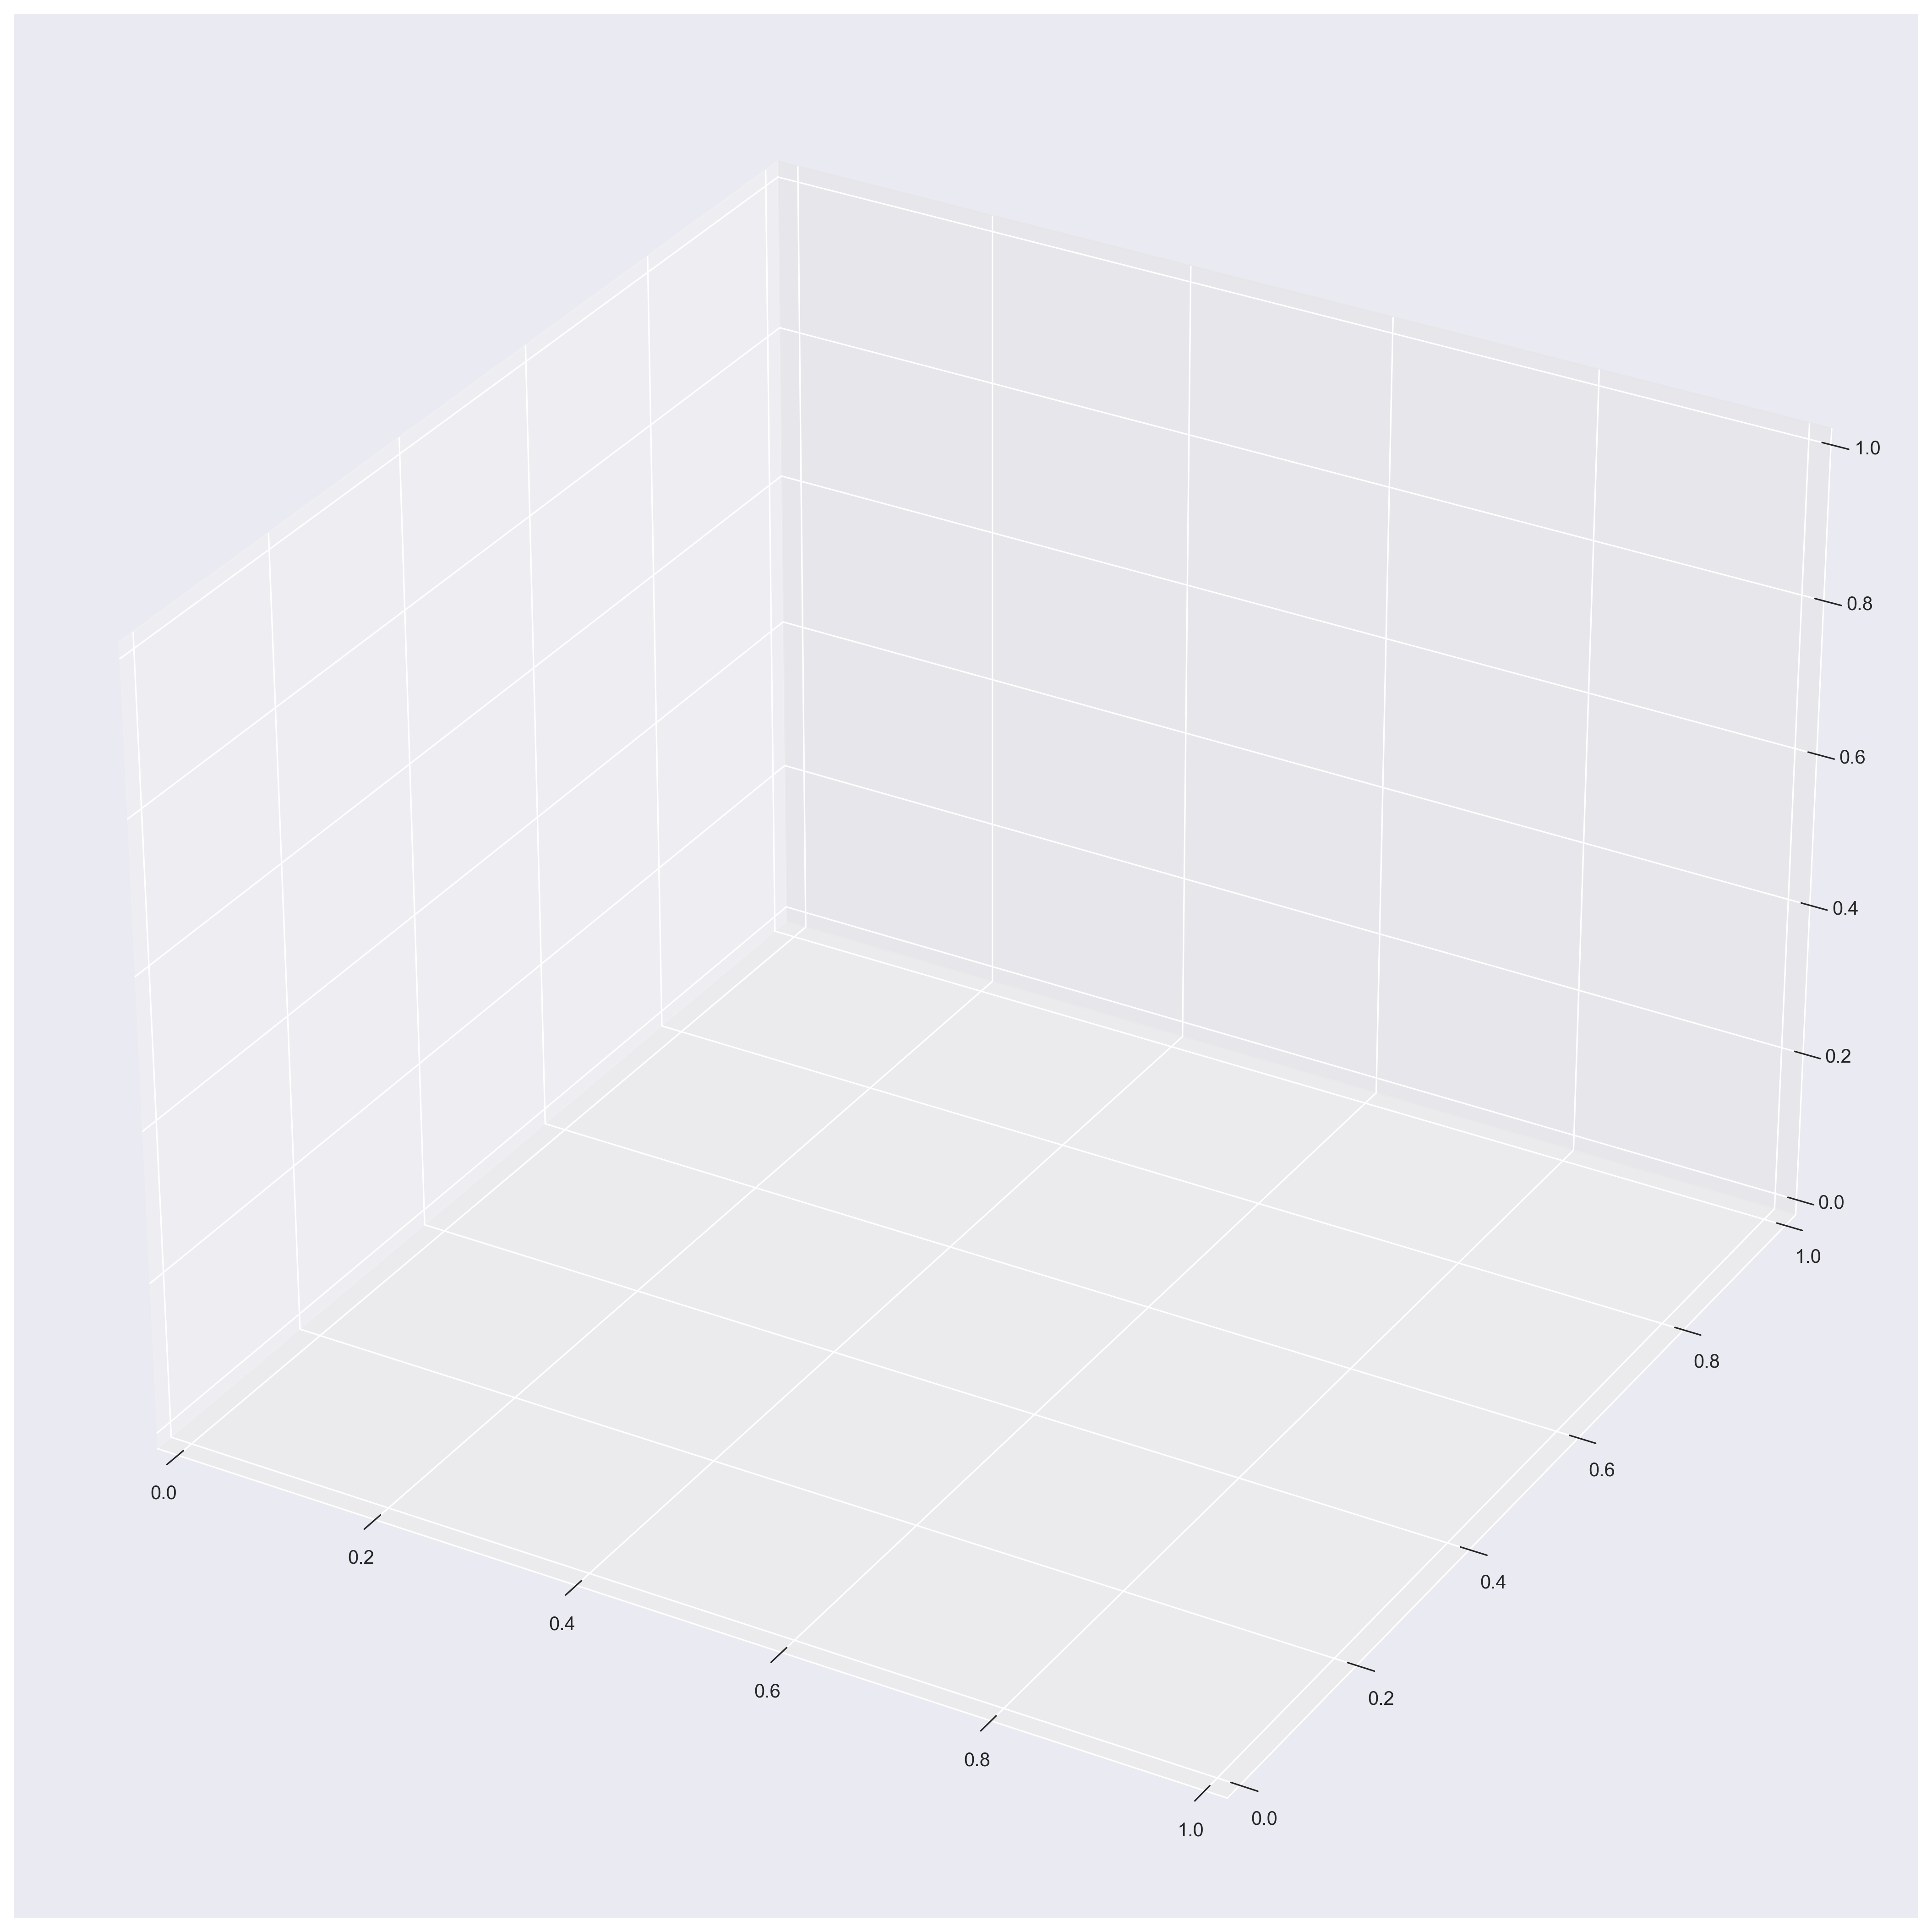

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource, LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

# Load the DEM file
dem_file = '../data/tif/uinta_merged.tif'
with rasterio.open(dem_file) as src:
    elevation = src.read(1)
    transform = src.transform

# Create coordinate grids
ny, nx = elevation.shape
x = np.linspace(0, nx - 1, nx)
y = np.linspace(0, ny - 1, ny)
x, y = np.meshgrid(x, y)

# Smooth elevation for aesthetics
from scipy.ndimage import gaussian_filter
smoothed_elevation = gaussian_filter(elevation, sigma=1)

# Set up figure for high-quality rendering
fig = plt.figure(figsize=(24, 18), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# Lighting and shading
light = LightSource(azdeg=225, altdeg=50)
custom_cmap = LinearSegmentedColormap.from_list(
    "custom_terrain",
    ['#2f1810', '#513620', '#6b4423', '#a69376', '#c7b8a1', '#e2d5c3', '#ffffff']
)
rgb = light.shade(smoothed_elevation, cmap=custom_cmap, blend_mode='overlay', vert_exag=2)

# Plot 3D surface
surf = ax.plot_surface(
    x, y, smoothed_elevation,
    facecolors=rgb, rstride=1, cstride=1, antialiased=True, linewidth=0
)

# Elevation contours (optional for extra detail)
ax.contour(x, y, smoothed_elevation, zdir='z', offset=smoothed_elevation.min(), cmap='Greys', alpha=0.5)

# Set labels and title
ax.set_title('Uinta Mountains: Snow Shadow and Elevation', fontsize=24, pad=40)
ax.set_xlabel('Longitude', fontsize=16, labelpad=20)
ax.set_ylabel('Latitude', fontsize=16, labelpad=20)
ax.set_zlabel('Elevation (m)', fontsize=16, labelpad=20)

# Adjust view angle
ax.view_init(elev=35, azim=225)

# Enhance axis aesthetics
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False)

# Save high-resolution image
output_file = 'uinta_basin_high_quality.png'
plt.savefig(output_file, dpi=600, bbox_inches='tight', facecolor='black', edgecolor='none')
plt.show()